In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings

data_dir = "/Users/vigadam/Dropbox/github/media_network/media_data/parliament_speech_text/data/"

warnings.filterwarnings("ignore")

## create observed ideology yc

In [7]:
parldata = pd.read_csv(data_dir + "parldata_2020.csv")
votedata = pd.read_csv(data_dir + "2018vote.csv",index_col = False)

In [8]:
votedata = votedata.rename(columns={"%": "perc", "Jelölt neve": "name"})
votedata["ideology"] = np.where(
    votedata["Jelölő szervezet(ek)"] == "FIDESZ-KDNP",
    votedata["perc"],
    -1 * votedata["perc"],
)

votedata["ideology"] = (votedata["ideology"] - votedata["ideology"].min()) / (
    votedata["ideology"].max() - votedata["ideology"].min()
)

In [9]:
votedata["name"] = votedata["name"].str.replace("Dr. ","")
parldata["speaker"] = parldata["speaker"].str.replace("Dr. ","")
votedata["name"] = votedata["name"].str.replace("V.Németh Zsolt","Németh Zsolt")
votedata["name"] = votedata["name"].str.replace("Vécsey László József","Vécsey László")
votedata["name"] = votedata["name"].str.replace("B Nagy László","B. Nagy László")

In [10]:
yc = (
    parldata.filter(["speaker", "oldal"])
    .rename(columns={"speaker": "name"})
    .merge(votedata.filter(["name", "ideology"]), how="left", on="name")
    .drop_duplicates("name")
)

In [11]:
yc.loc[lambda x: x["oldal"] == "Fidesz-KDNP", "ideology"] = yc.loc[
    lambda x: x["oldal"] == "Fidesz-KDNP", "ideology"
].fillna(yc.groupby("oldal")["ideology"].mean()["Fidesz-KDNP"])

yc.loc[lambda x: x["oldal"] == "ellenzék", "ideology"] = yc.loc[
    lambda x: x["oldal"] == "ellenzék", "ideology"
].fillna(yc.groupby("oldal")["ideology"].mean()["ellenzék"])

<AxesSubplot:>

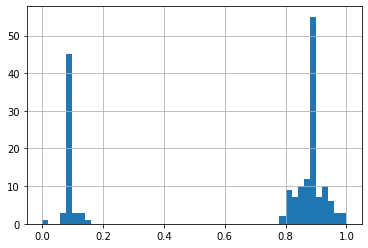

In [12]:
yc["ideology"].hist(bins=50)

In [13]:
yc.to_csv(data_dir + "yc.csv")

## Calculate  intercept and slope for all phrases

In [18]:
freq = pd.read_csv(data_dir + "frequency_of_stemed_phrases.csv")
yc = pd.read_csv(data_dir + "yc.csv")

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])

In [19]:
names = freq["name"]
yc = freq["ideology"]
Phases = freq.iloc[:, :-2].div(freq.sum(axis=1), axis=0)

In [20]:
p_a_b = pd.DataFrame(Phases.columns.tolist(), columns=["p"]).assign(a=None, b=None)

In [21]:
# estimate intercept and slope parameters
for i in range(0, p_a_b.shape[0]):
    X = Phases.iloc[:, i]
    X = sm.add_constant(X)

    model = sm.OLS(yc, X)
    results = model.fit()
    p_a_b.loc[i, "a"] = results.params[0]
    p_a_b.loc[i, "b"] = results.params[1]

<AxesSubplot:>

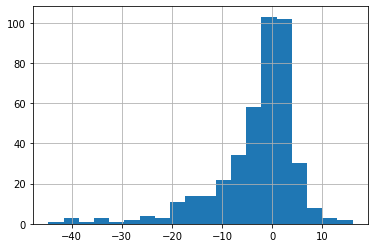

In [22]:
# slope
p_a_b["b"].sort_values().iloc[10:-4].hist(bins=20)

<AxesSubplot:>

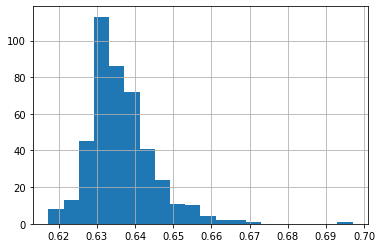

In [23]:
# intercept
p_a_b["a"].hist(bins=20)

In [24]:
p_a_b.to_csv(data_dir + "phrase_intercept_slope.csv")

##  in-sample evidence

In [10]:
freq = pd.read_csv(data_dir + "frequency_of_stemed_phrases.csv")
yc = pd.read_csv(data_dir + "yc.csv")
p_a_b = pd.read_csv(data_dir + "phrase_intercept_slope.csv")

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])

In [11]:
def predict_y_hat(freq, p_a_b):
    if "ideology" in freq.columns.tolist():
        Phases = freq.drop(columns=["name", "ideology"]).div(freq.sum(axis=1), axis=0)
    elif "name" in freq.columns.tolist():
        Phases = freq.drop(columns=["name"]).div(freq.sum(axis=1), axis=0)
    else:
        print("You should always have a 'name' columns in freq table")

    for i in range(Phases.shape[0]):

        out = (
            Phases.iloc[i, :]
            .T.rename("fpn")
            .reset_index()
            .merge(p_a_b, left_on="index", right_on="p")
            .drop(columns=["index"])
            .assign(
                f_minus_a_times_b=lambda x: (x["fpn"] - x["a"]) * x["b"],
                b_squared=lambda x: x["b"] * x["b"],
            )
            .sum(axis=0)
            .filter(["f_minus_a_times_b", "b_squared"])
        )

        freq.loc[i, "y_hat"] = out["f_minus_a_times_b"] / out["b_squared"]

    freq["y_hat_abs"] = freq["y_hat"]
    freq["y_hat"] = (freq["y_hat"] - freq["y_hat"].min()) / (
        freq["y_hat"].max() - freq["y_hat"].min()
    )

    if "ideology" in freq.columns.tolist():
        prediction_table = freq.filter(
            ["name", "ideology", "y_hat", "y_hat_abs"]
        ).sort_values(by=["y_hat"])
    else:
        prediction_table = freq.filter(["name", "y_hat", "y_hat_abs"]).sort_values(
            by=["y_hat"]
        )

    return prediction_table.reset_index(drop=True)

In [12]:
insample_pred = predict_y_hat(freq, p_a_b)

<AxesSubplot:xlabel='ideology', ylabel='y_hat'>

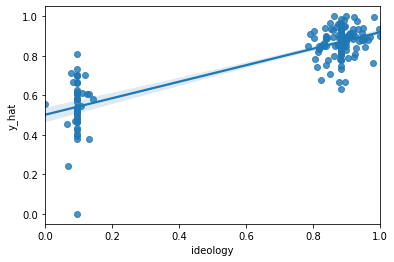

In [13]:
sns.regplot(data=insample_pred, x="ideology", y="y_hat")

In [14]:
insample_pred[["ideology", "y_hat"]].corr()

,ideology,y_hat
ideology,1.000000,0.859753
y_hat,0.859753,1.000000


## prediction on media

In [15]:
freq = pd.read_csv(data_dir + "frequency_of_stemed_media_phrases.csv").rename(
    columns={"doc_id": "name"}
)
p_a_b = pd.read_csv(data_dir + "phrase_intercept_slope.csv")

In [16]:
pred = predict_y_hat(freq, p_a_b)

pred["name"] = pred["name"].map(
    {
        "mno": "Magyar Nemzet",
        "888": "888.hu\n\n",
        "origo": "Origo",
        "Index": "Index",
        "444": "444.hu",
        "24.hu": "24.hu",
    }
)

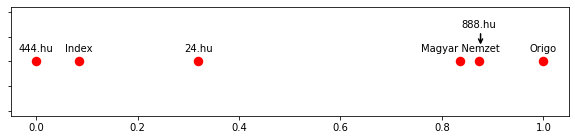

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# this is the value where you want the data to appear on the y-axis.

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(
    pred["y_hat"],
    np.zeros_like(pred["y_hat"]),
    ".",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="r",
    markerfacecolor="r",
)
ax.set_yticklabels([])

# ax.set_ylim([ymin,ymax])

for i, txt in enumerate(pred["name"]):
    ax.annotate(
        txt,
        (pred["y_hat"][i], np.zeros_like(pred["y_hat"])[i]),
        xytext=(pred["y_hat"][i], np.zeros_like(pred["y_hat"])[i] + 0.01),
        ha="center",
    )

ax.annotate(
    "",
    xy=(pred.loc[lambda x: x["name"] == "888.hu\n\n", "y_hat"]+0.004, 0.015),
    xytext=(pred.loc[lambda x: x["name"] == "888.hu\n\n", "y_hat"]+0.004, 0.03),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)


plt.savefig("GS-scaling-v1.png")
plt.show()